In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0. Instalar pacotes e importar bibliotecas

In [ ]:
!pip install optuna # Tunar hiperparâmetro
!pip install category_encoders
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00


In [ ]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import pandas            as pd
import seaborn           as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, ShuffleSplit
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, \
HistGradientBoostingClassifier,StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, make_scorer, accuracy_score, precision_score, recall_score, auc, precision_recall_curve, average_precision_score
import optuna
import pickle
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# 1. Funções auxiliares

In [ ]:
# Métricas do modelo

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })
    return metrics_df

def calculate_metrics_train(nm_modelo, X_train, y_train):
    # Fazendo predições
    y_train_prob = X_train.SCORE_FRAUDE
    y_train_pred = (y_train_prob > 0.5).astype(int)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, y_train_prob)

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = y_train_prob
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo],
        'Conjunto': ['Treino'],
        'Acuracia': [accuracy_train],
        'Precisao': [precision_train],
        'Recall': [recall_train],
        'AUC_ROC': [auc_roc_train],
        'GINI': [gini_index_train],
        'KS': [ks_statistic_train]
    })
    return metrics_df

def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# 2. Leitura dos datasets

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Prevencao_fraude/df_train_full.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Prevencao_fraude/df_test_full.csv')

abt_vigente = pd.read_csv('/content/drive/MyDrive/Prevencao_fraude/abt_vigente_score.csv')

# Colocando nomes das colunas em maiúsculo
df_train.columns = df_train.columns.str.upper()
df_test.columns = df_test.columns.str.upper()
abt_vigente.columns = abt_vigente.columns.str.upper()

In [ ]:
abt_vigente.head()

,TRANSACTION_ID,TX_AMOUNT,TX_FRAUD,MEAN_AMOUNT,STD_AMOUNT,MEAN_NB_TX_PER_DAY,SCORE_FRAUDE
0,59452,61.51,0,62.262521,31.13126,2.179533,13
1,59592,129.61,0,62.262521,31.13126,2.179533,809
2,60132,96.50,0,62.262521,31.13126,2.179533,762
3,60721,82.19,0,62.262521,31.13126,2.179533,555
4,61033,50.77,0,62.262521,31.13126,2.179533,600


In [ ]:
df_train.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,X_CUSTOMER_ID,Y_CUSTOMER_ID,MEAN_AMOUNT,STD_AMOUNT,...,RATIO_MEAN_AMOUNT_PER_CUSTOMER_LAST1H_TO_8H,RATIO_MEAN_AMOUNT_PER_CUSTOMER_LAST1H_TO_24H,RATIO_MEAN_AMOUNT_PER_CUSTOMER_LAST1H_TO_7D,RATIO_MEAN_AMOUNT_PER_CUSTOMER_LAST1H_TO_14D,RATIO_TOTAL_TRANSACTIONS_PER_CUSTOMER_LAST1H_TO_2H,RATIO_TOTAL_TRANSACTIONS_PER_CUSTOMER_LAST1H_TO_4H,RATIO_TOTAL_TRANSACTIONS_PER_CUSTOMER_LAST1H_TO_8H,RATIO_TOTAL_TRANSACTIONS_PER_CUSTOMER_LAST1H_TO_24H,RATIO_TOTAL_TRANSACTIONS_PER_CUSTOMER_LAST1H_TO_7D,RATIO_TOTAL_TRANSACTIONS_PER_CUSTOMER_LAST1H_TO_14D
0,59452,2021-08-01 03:01:00,0,1133,61.51,0,10.95017,59.768684,62.262521,31.13126,...,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.000000
1,59592,2021-08-01 05:30:38,0,1138,129.61,0,10.95017,59.768684,62.262521,31.13126,...,1.356321,1.356321,1.356321,1.356321,1.0,0.5,0.500000,0.500000,0.500000,0.500000
2,60132,2021-08-01 10:40:12,0,1530,96.50,0,10.95017,59.768684,62.262521,31.13126,...,1.006536,1.006536,1.006536,1.006536,1.0,1.0,0.333333,0.333333,0.333333,0.333333
3,60721,2021-08-01 15:38:25,0,241,82.19,0,10.95017,59.768684,62.262521,31.13126,...,0.919917,0.888997,0.888997,0.888997,1.0,1.0,0.500000,0.250000,0.250000,0.250000
4,61033,2021-08-01 19:25:30,0,1536,50.77,0,10.95017,59.768684,62.262521,31.13126,...,0.763688,0.603571,0.603571,0.603571,1.0,0.5,0.500000,0.200000,0.200000,0.200000


# 3. Preparação dos Dados

In [ ]:
X = df_train.drop(columns=['TX_FRAUD','TRANSACTION_ID',	'TX_DATETIME',	'CUSTOMER_ID',	'TERMINAL_ID','X_CUSTOMER_ID','Y_CUSTOMER_ID','X_TERMINAL_ID','Y_TERMINAL_ID'])
y = df_train['TX_FRAUD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

cat_attributes = X_train.select_dtypes(include='object')
num_attributes = X_train.select_dtypes(exclude='object')

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes.columns),
    ('num', num_pipe, num_attributes.columns)
])
preprocesssor = Pipeline(steps=[("preprocessor", preprocessor)])

X_train_processed = pd.DataFrame(preprocesssor.fit_transform(X_train, y_train),columns=X_train.columns)
X_test_processed = pd.DataFrame(preprocesssor.transform(X_test),columns=X_test.columns)

In [ ]:
X_train_processed.head()

,TX_AMOUNT,MEAN_AMOUNT,STD_AMOUNT,MEAN_NB_TX_PER_DAY,MONTH_REFERENCE,PERIODO_DIA,HOUR_OF_DAY,DAY_OF_WEEK,DAY_OF_MONTH,MONTH,...,RATIO_MEAN_AMOUNT_PER_CUSTOMER_LAST1H_TO_8H,RATIO_MEAN_AMOUNT_PER_CUSTOMER_LAST1H_TO_24H,RATIO_MEAN_AMOUNT_PER_CUSTOMER_LAST1H_TO_7D,RATIO_MEAN_AMOUNT_PER_CUSTOMER_LAST1H_TO_14D,RATIO_TOTAL_TRANSACTIONS_PER_CUSTOMER_LAST1H_TO_2H,RATIO_TOTAL_TRANSACTIONS_PER_CUSTOMER_LAST1H_TO_4H,RATIO_TOTAL_TRANSACTIONS_PER_CUSTOMER_LAST1H_TO_8H,RATIO_TOTAL_TRANSACTIONS_PER_CUSTOMER_LAST1H_TO_24H,RATIO_TOTAL_TRANSACTIONS_PER_CUSTOMER_LAST1H_TO_7D,RATIO_TOTAL_TRANSACTIONS_PER_CUSTOMER_LAST1H_TO_14D
0,0.021826,0.019725,-0.197122,1.241692,1.241692,0.450039,1.422486,-1.090777,-0.486728,0.715921,...,0.002591,-0.426376,-0.991283,-0.776378,0.379072,0.661341,0.986930,-0.651548,-0.094260,-0.250625
1,0.021826,0.019725,-0.402225,0.567883,0.567883,-2.181832,0.714993,-0.695512,1.012278,-0.309685,...,0.002591,0.000172,-1.235326,-1.100386,0.379072,0.661341,0.986930,2.216140,1.121227,1.115472
2,0.022658,0.017819,-0.555295,-0.487752,-0.487752,0.572798,0.007501,0.095018,1.012278,-1.563202,...,-0.649090,-0.056576,-0.605327,-0.610125,0.379072,-1.364632,-1.286620,-0.651548,-0.554672,-0.368682
3,0.021826,0.017427,2.707922,1.651034,1.651034,1.162627,1.422486,-0.300247,1.012278,1.057789,...,0.806277,0.633017,1.270654,1.017755,0.379072,-1.364632,-0.718232,-0.842727,-0.442446,-0.353925
4,0.024280,0.019725,-1.211525,-1.685450,-1.685450,-0.989720,-0.699992,1.478445,0.012941,-0.765509,...,0.002591,0.000172,0.396795,-0.115980,0.379072,0.661341,0.986930,2.216140,0.380540,0.064196


# 4. Modelagem

In [ ]:
# Testar outros modelos

algoritmos = [DecisionTreeClassifier(criterion='gini',random_state=0),
            LogisticRegression(solver='liblinear',random_state=0),
            RandomForestClassifier(random_state=0),
            GradientBoostingClassifier(random_state=0),
            XGBClassifier(random_state=0),
            lgb.LGBMClassifier(random_state=0)]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_processed,y_train)

    # Avaliar modelo
    metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
    display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTreeClassifier,Treino,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,DecisionTreeClassifier,Teste,0.963277,0.087426,0.068514,0.526101,0.052201,0.061481


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.983492,0.855869,0.327087,0.978920,0.957841,0.869968
1,LogisticRegression,Teste,0.974694,0.249284,0.066975,0.664432,0.328864,0.267489


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
1,RandomForestClassifier,Teste,0.97569,0.301695,0.068514,0.691568,0.383136,0.313274


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,GradientBoostingClassifier,Treino,0.985368,0.852521,0.428923,0.986132,0.972263,0.904946
1,GradientBoostingClassifier,Teste,0.974333,0.224719,0.061586,0.607139,0.214279,0.220479


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,XGBClassifier,Treino,0.995326,0.988128,0.803521,0.999332,0.998665,0.976048
1,XGBClassifier,Teste,0.973973,0.233415,0.073133,0.724833,0.449667,0.360471


[LightGBM] [Info] Number of positive: 5283, number of negative: 227701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.346724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21430
[LightGBM] [Info] Number of data points in the train set: 232984, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022675 -> initscore=-3.763539
[LightGBM] [Info] Start training from score -3.763539


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.989600,0.922827,0.590763,0.996126,0.992251,0.949121
1,LGBMClassifier,Teste,0.973853,0.217172,0.066205,0.652223,0.304446,0.231707


# 5. Avaliação da Performance do Modelo Vigente

In [ ]:
metricas_vigente = calculate_metrics_train('Modelo Vigente', abt_vigente,y)
display(metricas_vigente)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,Modelo Vigente,Treino,0.023596,0.0226,0.998936,0.500947,0.001894,0.005609


## 6. Visualização de algumas métricas para o algoritmo que teve melhor desempenho

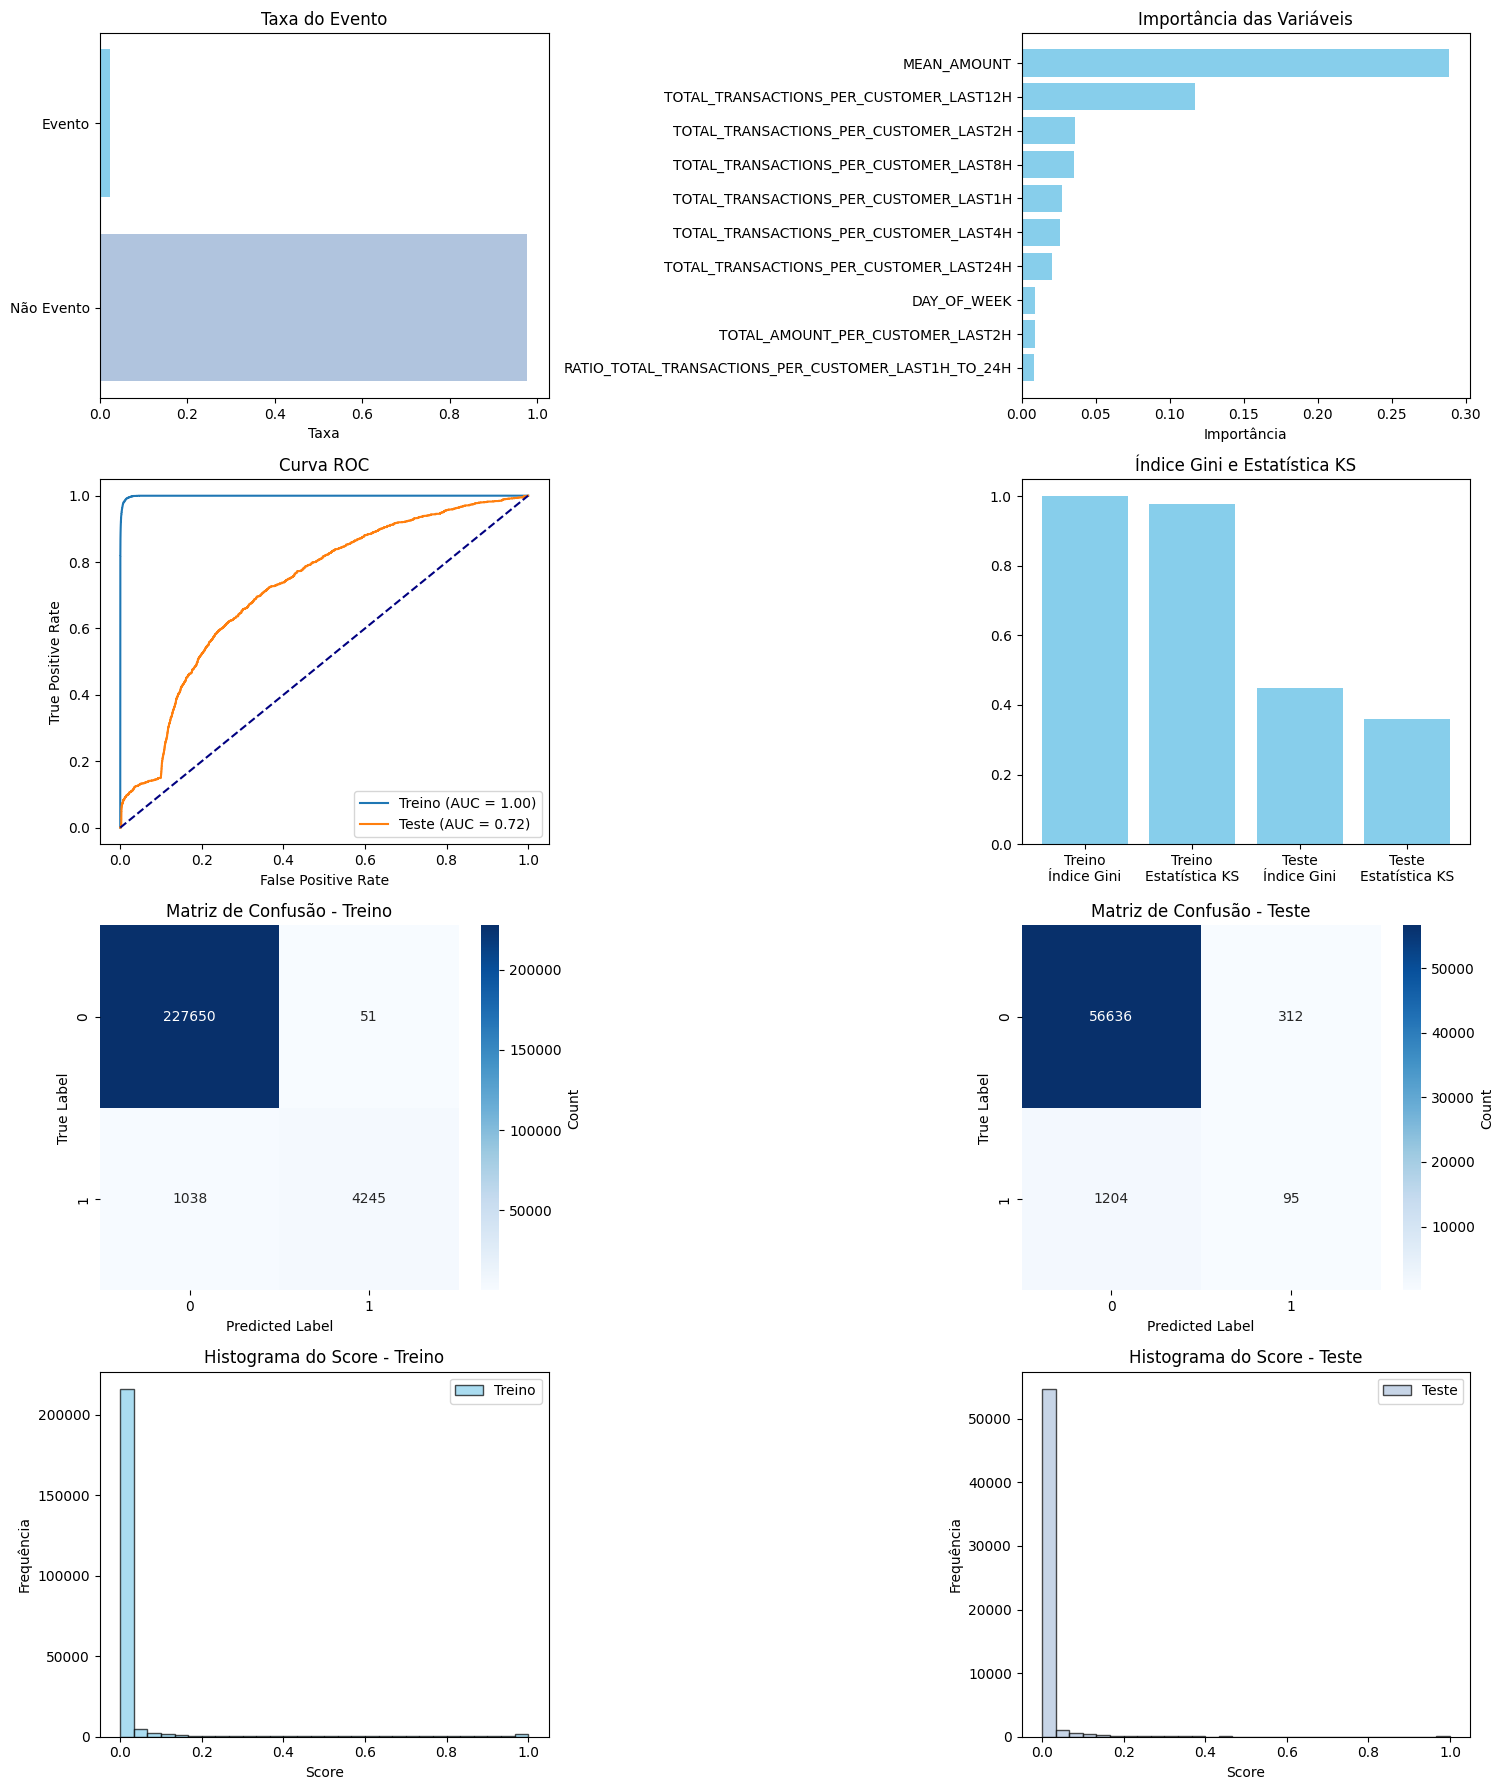

In [ ]:
features = X_train_processed.columns
best_algorithm = XGBClassifier(random_state=0)
best_algorithm.fit(X_train_processed,y_train)
plot_metrics(best_algorithm, X_train_processed, y_train, X_test_processed, y_test, features)

## 7. Curva Precision Recall

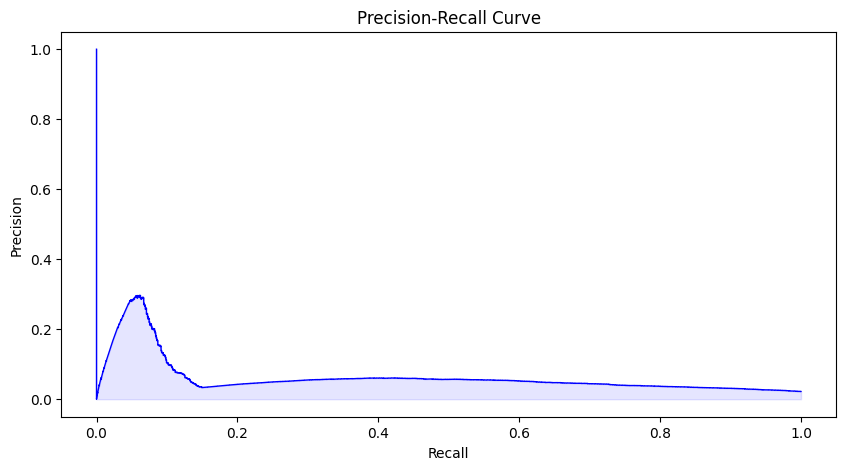

In [ ]:
y_probs = best_algorithm.predict_proba(X_test_processed)[:,1]
y_pred = best_algorithm.predict(X_test_processed)

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Precision-Recall curve
plt.figure(figsize=(10,5))
plt.plot(recall, precision, color="b", lw=1)
plt.fill_between(recall, precision, alpha=0.1, color="blue")
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision');

### 7.1 Classification Report sem alteração na configuração padrão do Threshold (0.5)

In [ ]:
# Avaliação do modelo ajustado
from sklearn.metrics import classification_report

print("Relatório de classificação com novo limiar:")
print(classification_report(y_test, y_pred))

Relatório de classificação com novo limiar:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     56948
           1       0.23      0.07      0.11      1299

    accuracy                           0.97     58247
   macro avg       0.61      0.53      0.55     58247
weighted avg       0.96      0.97      0.97     58247



### 7.2 Classification Report após alteração no Threshold

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Obtenção das probabilidades para a classe positiva
y_probs = best_algorithm.predict_proba(X_test_processed)[:, 1]

# Calcula Precision, Recall e os thresholds correspondentes
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Evitar divisão por zero - filtrando F1-Scores válidos
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Pequeno valor para evitar divisão por zero

# Encontra o índice do threshold que maximiza o F1-Score
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]

# Mostra o melhor threshold e o F1-Score correspondente
print(f"Melhor threshold para maximizar Precision e Recall: {best_threshold:.3f}")
print(f"F1-Score correspondente: {f1_scores[best_index]:.3f}")

# Aplica o novo limiar para ajustar as predições
y_pred_adjusted = (y_probs >= best_threshold).astype(int)

# Avaliação do modelo ajustado
from sklearn.metrics import classification_report

print("Relatório de classificação com novo limiar:")
print(classification_report(y_test, y_pred_adjusted))

Melhor threshold para maximizar Precision e Recall: 0.390
F1-Score correspondente: 0.117
Relatório de classificação com novo limiar:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     56948
           1       0.20      0.08      0.12      1299

    accuracy                           0.97     58247
   macro avg       0.59      0.54      0.55     58247
weighted avg       0.96      0.97      0.97     58247



## 8. Tunagem de hiperparâmetros

In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score
from optuna.samplers import TPESampler

# Função objetivo para otimização do XGBoost
def objective(trial):
    # Sugerir hiperparâmetros para o XGBoost
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 0,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    # Definir o modelo XGBoost com os hiperparâmetros sugeridos
    model = XGBClassifier(**param)

    # Pipeline com preprocessador e modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Treinar o pipeline
    pipeline.fit(X_train, y_train)

    # Prever as probabilidades no conjunto de validação
    y_pred_probs = pipeline.predict_proba(X_test)[:, 1]

    # Calcular AUC-ROC
    auc = roc_auc_score(y_test, y_pred_probs)

    return auc

# Classe para parada antecipada se não houver melhora após 20 iterações
class EarlyStoppingCallback:
    def __init__(self, patience: int):
        self.patience = patience
        self.best_score = None
        self.num_no_improvement = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        current_score = study.best_value
        if self.best_score is None or current_score > self.best_score:
            self.best_score = current_score
            self.num_no_improvement = 0
        else:
            self.num_no_improvement += 1

        if self.num_no_improvement >= self.patience:
            study.stop()

# Configurar o Early Stopping Callback
early_stopping = EarlyStoppingCallback(patience=20)

# Criar o estudo com a seed para reprodutibilidade
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=0))
study.optimize(objective, n_trials=150, n_jobs=-1, callbacks=[early_stopping])

# Melhor conjunto de hiperparâmetros encontrado
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor AUC-ROC: {study.best_value:.4f}")

In [ ]:
best_params = {'n_estimators': 497, 'max_depth': 9, 'learning_rate': 0.05064131970082176, 'subsample': 0.9017014890228775, 'colsample_bytree': 0.7349176134551406, 'gamma': 3.357582904408152e-05, 'reg_alpha': 0.9974231664030752, 'reg_lambda': 3.4312469095456225e-05, 'min_child_weight': 5}

### 8.1 Treinar algoritmo com a melhor configuração de hiperparâmetros

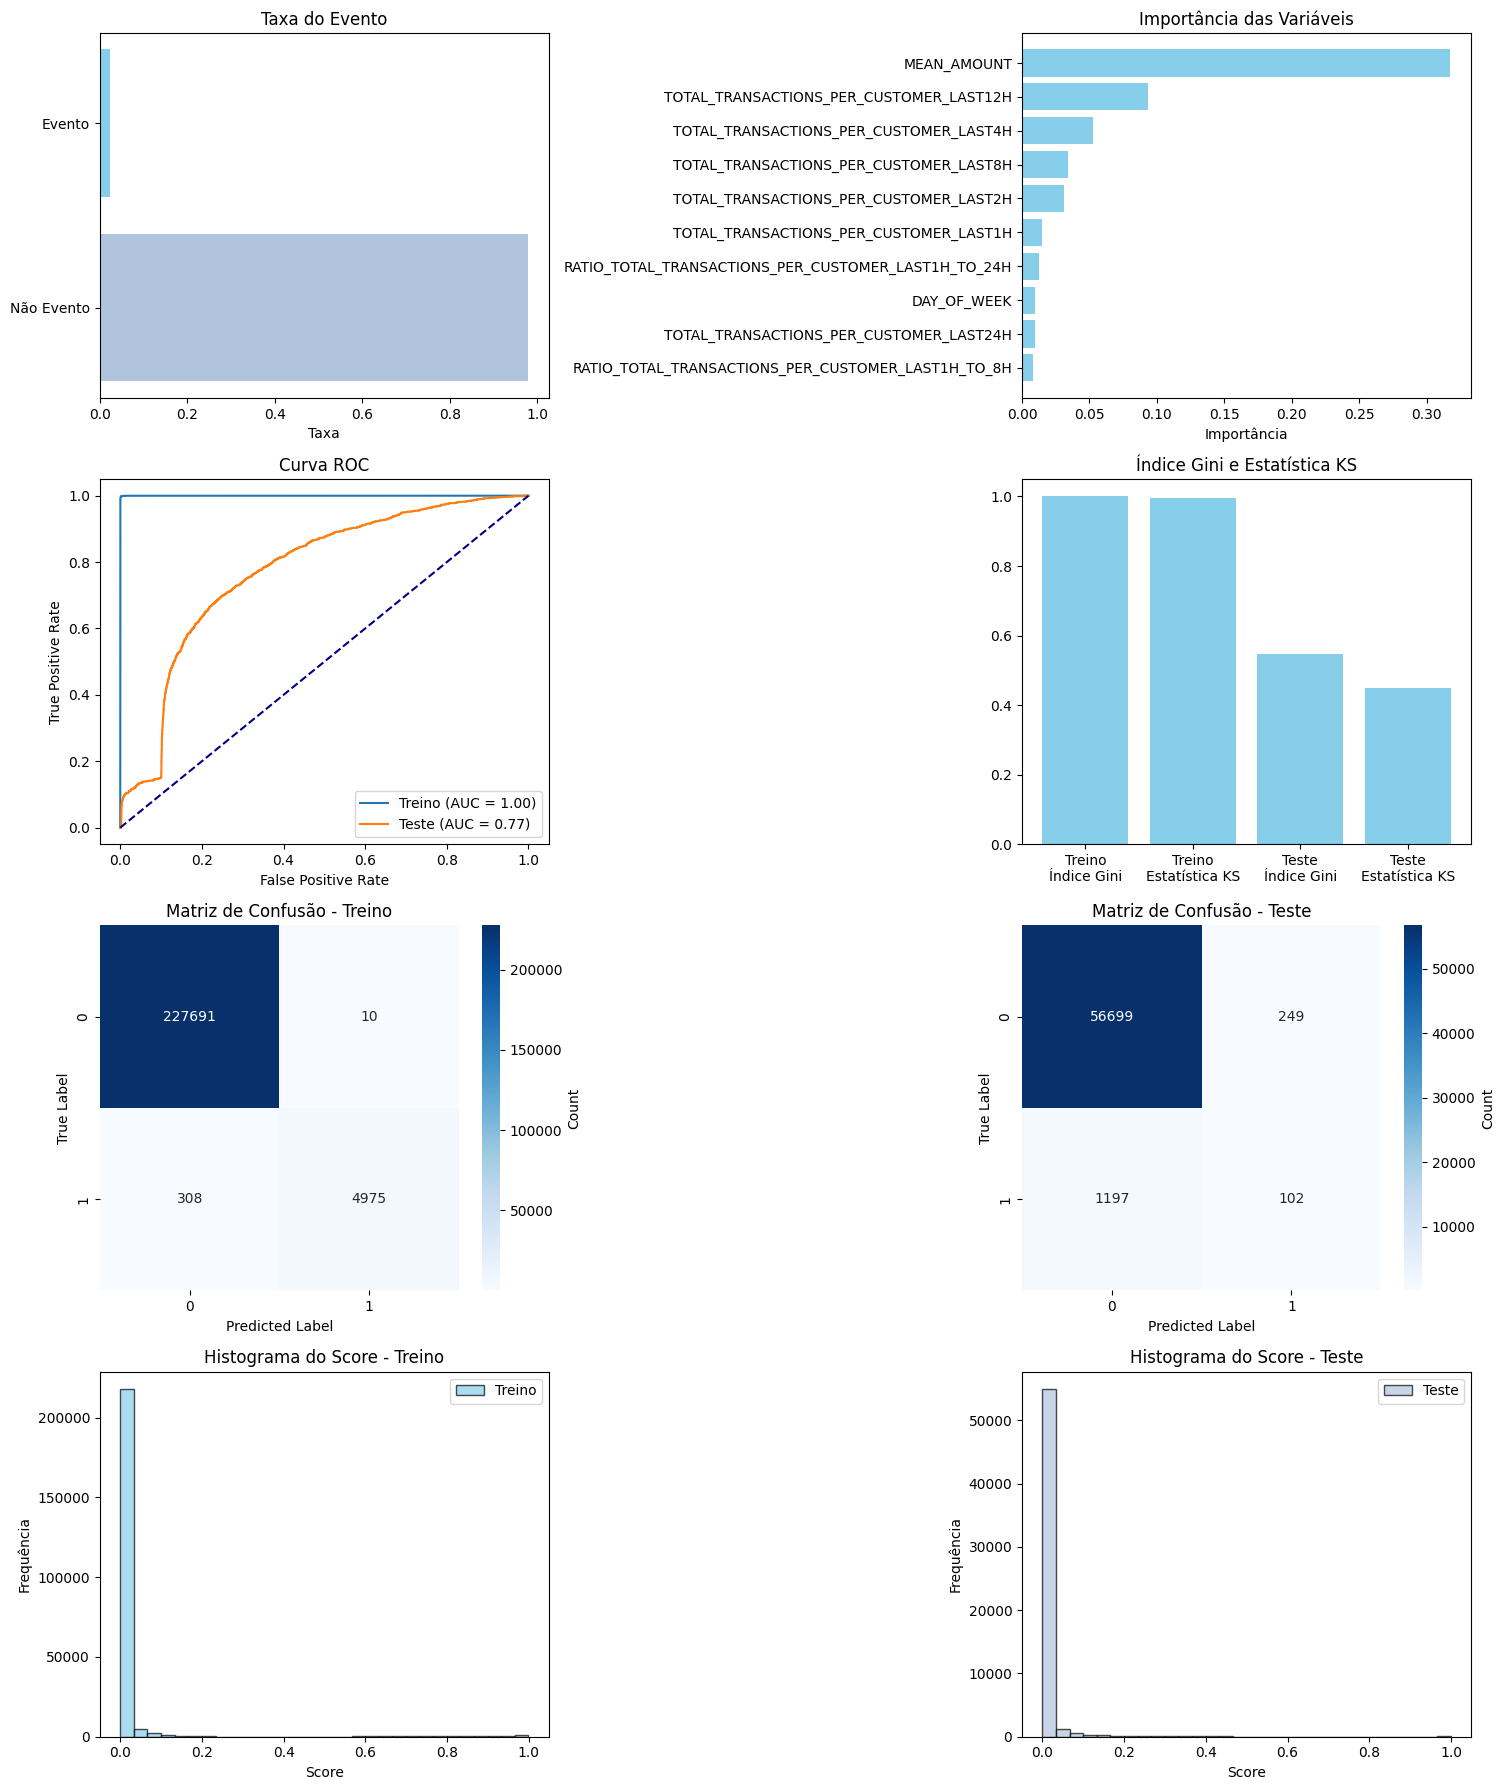

In [ ]:
features = X_train_processed.columns
best_algorithm_tuned = XGBClassifier(random_state=0,**best_params)
best_algorithm_tuned.fit(X_train_processed,y_train)
plot_metrics(best_algorithm_tuned, X_train_processed, y_train, X_test_processed, y_test, features)

# features = X_train_processed.columns
# best_algorithm_tuned = XGBClassifier(random_state=0,**study.best_params)
# best_algorithm_tuned.fit(X_train_processed,y_train)
# plot_metrics(best_algorithm_tuned, X_train_processed, y_train, X_test_processed, y_test, features)

### 8.2 Curva Precision Recall após tunar algoritmo

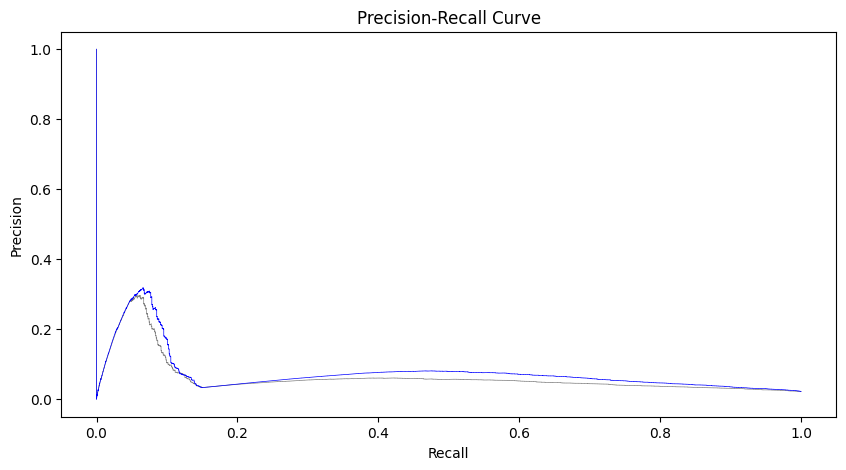

In [ ]:
# Curva com algoritmo antes do tuning
y_probs = best_algorithm.predict_proba(X_test_processed)[:,1]
y_pred = best_algorithm.predict(X_test_processed)

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(10,5))
plt.plot(recall, precision, color="gray", lw=0.5)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision');

# ----------------------------------------------------------------------------

# Curva com algoritmo após o tuning
y_probs_tuned = best_algorithm_tuned.predict_proba(X_test_processed)[:,1]
y_pred_tuned = best_algorithm_tuned.predict(X_test_processed)

precision_tuned, recall_tuned, thresholds_tuned = precision_recall_curve(y_test, y_probs_tuned)

plt.plot(recall_tuned, precision_tuned, color="b", lw=0.5)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision');

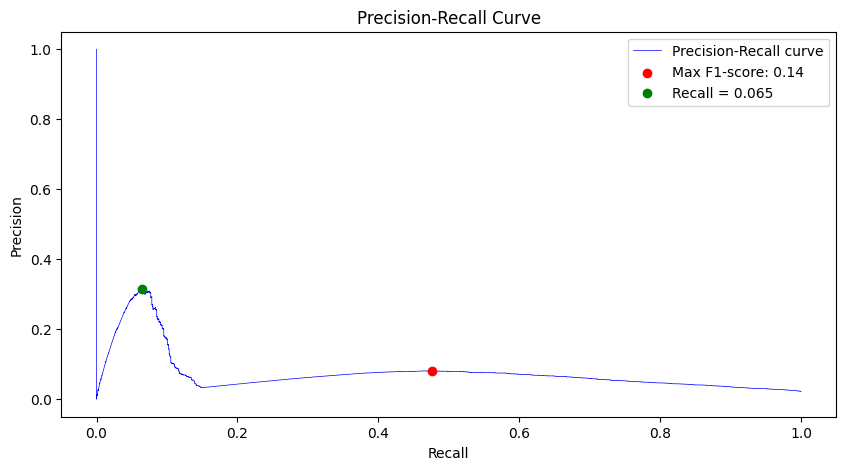

Priorizando a configuração de melhor F1-score:
Melhor F1-score: 0.1385
Threshold correspondente ao F1-score máximo: 4.178758535999805e-05
Precision: 0.08101730466701626
Recall: 0.47575057736720555
----------------------------------------------------------------------
Priorizando outra configuração com menor recall entretanto um maior precision:
Precision: 0.3146
Recall: 0.0647
Threshold: 0.6541081070899963
F1-score: 0.1077401213556312


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

# Supondo que você já tenha os arrays: y_true e y_pred_proba
precision_tuned, recall_tuned, thresholds_tuned = precision_recall_curve(y_test, y_probs_tuned)

# Calcular o F1-score para cada ponto
f1_scores = 2 * (precision_tuned * recall_tuned) / (precision_tuned + recall_tuned + 1e-32)

# Encontrar o índice que maximiza o F1-score
best_f1_index = np.argmax(f1_scores)
best_threshold = thresholds_tuned[best_f1_index - 1]  # -1 para alinhar com o tamanho do array de thresholds
best_f1_score = f1_scores[best_f1_index]

# Encontrar o índice onde o recall é aproximadamente 0.065
recall_target = 0.065
recall_index = (np.abs(recall_tuned - recall_target)).argmin()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 5))
plt.plot(recall_tuned, precision_tuned, color='b', lw=0.5, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Marcar o ponto de F1-score máximo
plt.scatter(recall_tuned[best_f1_index], precision_tuned[best_f1_index], color='red', label=f'Max F1-score: {best_f1_score:.2f}', zorder=2)

# Marcar o ponto onde recall é 0.065
plt.scatter(recall_tuned[recall_index], precision_tuned[recall_index], color='green', label=f'Recall = {recall_target}', zorder=2)

plt.legend()
plt.show()

print('Priorizando a configuração de melhor F1-score:')
print(f'Melhor F1-score: {best_f1_score:.4f}')
print(f'Threshold correspondente ao F1-score máximo: {best_threshold}')
print(f'Precision: {precision_tuned[best_f1_index]}')
print(f'Recall: {recall_tuned[best_f1_index]}')

f1_score = 2 * (precision_tuned[recall_index] * recall_target) / (precision_tuned[recall_index] + recall_target + 1e-32)
print(70*'-')
print('Priorizando outra configuração com menor recall entretanto um maior precision:')
print(f'Precision: {precision_tuned[recall_index]:.4f}')
print(f'Recall: {recall_tuned[recall_index]:.4f}')
print(f'Threshold: {thresholds_tuned[recall_index-1]:.16f}')
print(f'F1-score: {f1_score}')


In [ ]:
# Exemplo de teste alterando o threshold
y_pred_aux = (y_probs_tuned >= 0.6541081070899963).astype(int)
print(classification_report(y_test, y_pred_aux))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     56948
           1       0.32      0.07      0.11      1299

    accuracy                           0.98     58247
   macro avg       0.65      0.53      0.55     58247
weighted avg       0.96      0.98      0.97     58247



## 9. Análise de variáveis importantes para o modelo

### 9.1 Visualização das 15 variáveis mais importantes

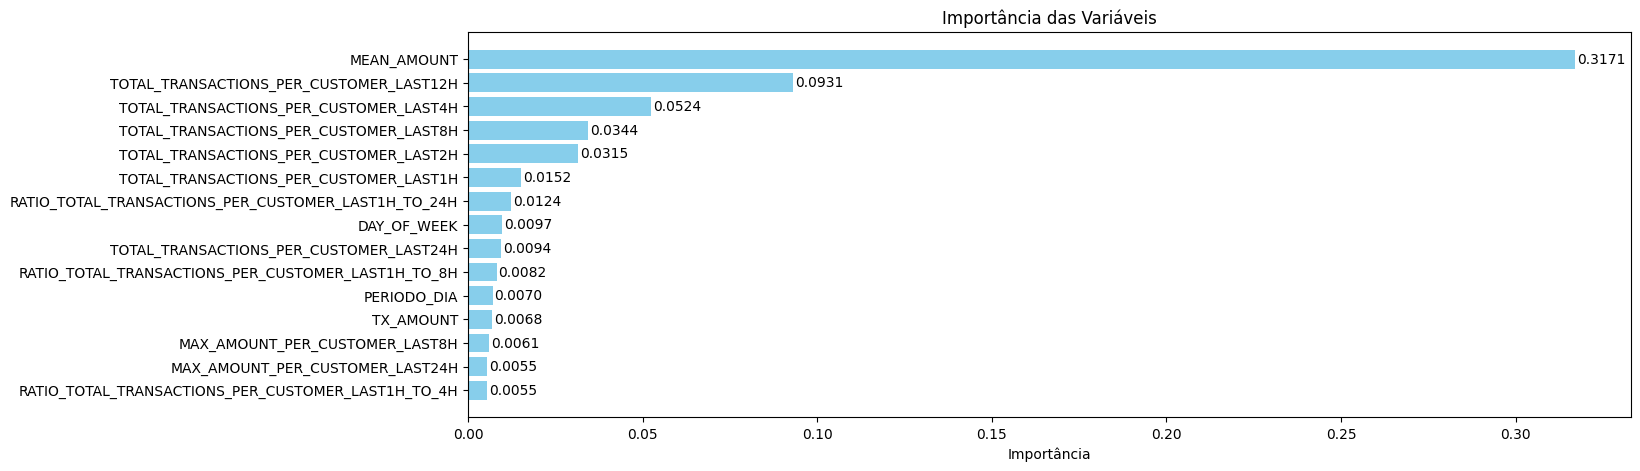

In [ ]:
plt.figure(figsize=(15,5))

importances = best_algorithm_tuned.feature_importances_
indices = np.argsort(importances)  # Ordem ascendente
indices = indices[-15:]  # Considerando apenas as 15 mais importantes

plt.barh(features[indices], importances[indices], color='skyblue')
plt.xlabel('Importância')
plt.title('Importância das Variáveis')

# Adicionar os valores de importância ao lado de cada barra
for i, v in enumerate(importances[indices]):
    plt.text(v + 0.0005, i, f'{v:.4f}', va='center')  # Ajuste o valor necessário para espaçamento

plt.show()

### 9.2 Checar quantidade de variáveis que entraram no modelo

In [ ]:
qtd_vars_modelo = (importances > 0).sum()
print(f'Quantidade de variáveis que entraram no modelo: {qtd_vars_modelo}')

Quantidade de variáveis que entraram no modelo: 109


### 9.3 Checar tempo para predição de uma instância

In [ ]:
%%time
score_fraude = best_algorithm_tuned.predict_proba(X_test_processed.iloc[[0]])[:,1]

CPU times: user 31 ms, sys: 2.98 ms, total: 34 ms
Wall time: 35.7 ms


### 9.4 Checar desempenho do modelo

In [ ]:
metricas = calculate_metrics('XGBoost',best_algorithm_tuned, X_train_processed, y_train, X_test_processed, y_test)
display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,XGBoost,Treino,0.998635,0.997994,0.941700,0.999971,0.999942,0.995782
1,XGBoost,Teste,0.975175,0.290598,0.078522,0.774046,0.548093,0.449218


### 9.5 Selecionar as 50 variáveis mais importantes para o modelo e checar latência, desempenho

In [ ]:
indices = np.argsort(importances)  # Ordem ascendente
indices = indices[-50:]  # Considerando apenas as 50 mais importantes
vars_selected_v1 = features[indices].to_list()

modelo_simplificado_v1 = best_algorithm_tuned.fit(X_train_processed[vars_selected_v1],y_train)

In [ ]:
%%time
score_fraude = modelo_simplificado_v1.predict_proba(X_test_processed[vars_selected_v1].iloc[[0]])[:,1]

CPU times: user 24.6 ms, sys: 0 ns, total: 24.6 ms
Wall time: 23.8 ms


In [ ]:
metricas = calculate_metrics('XGBoost',modelo_simplificado_v1, X_train_processed[vars_selected_v1], y_train, X_test_processed[vars_selected_v1], y_test)
display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,XGBoost,Treino,0.997519,0.992877,0.897028,0.999889,0.999778,0.991821
1,XGBoost,Teste,0.975003,0.287263,0.081601,0.789253,0.578505,0.480786


### 9.6 Selecionar as 25 variáveis mais importantes para o modelo e checar latência, desempenho

In [ ]:
indices = np.argsort(importances)  # Ordem ascendente
indices = indices[-25:]  # Considerando apenas as 25 mais importantes
vars_selected_v2 = features[indices].to_list()

modelo_simplificado_v2 = best_algorithm_tuned.fit(X_train_processed[vars_selected_v2],y_train)

In [ ]:
%%time
score_fraude = modelo_simplificado_v2.predict_proba(X_test_processed[vars_selected_v2].iloc[[0]])[:,1]

CPU times: user 15.8 ms, sys: 4 µs, total: 15.8 ms
Wall time: 15.2 ms


In [ ]:
metricas = calculate_metrics('XGBoost',modelo_simplificado_v2, X_train_processed[vars_selected_v2], y_train, X_test_processed[vars_selected_v2], y_test)
display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,XGBoost,Treino,0.994768,0.983349,0.782510,0.999359,0.998717,0.978264
1,XGBoost,Teste,0.974265,0.252475,0.078522,0.726154,0.452308,0.358098


### 9.7 Tunar hiperparâmetros da versão simplificada v1

### 9.7.1 Maximizando ROC-AUC

In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from optuna.samplers import TPESampler

# Definir o pipeline
cat_attributes_vars_selected_v1 = X_train[vars_selected_v1].select_dtypes(include='object')
num_attributes_vars_selected_v1 = X_train[vars_selected_v1].select_dtypes(exclude='object')

# Define categorical pipeline
cat_pipe_vars_selected_v1 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

# Define numerical pipeline
num_pipe_vars_selected_v1 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

# Combine categorical and numerical pipelines
preprocessor_vars_selected_v1 = ColumnTransformer([
    ('cat', cat_pipe_vars_selected_v1, cat_attributes_vars_selected_v1.columns),
    ('num', num_pipe_vars_selected_v1, num_attributes_vars_selected_v1.columns)
])
preprocessor_vars_selected_v1 = Pipeline(steps=[("preprocessor", preprocessor_vars_selected_v1)])



# Inicializar os hiperparâmetros conhecidos
init_params = {
    'n_estimators': 497,
    'max_depth': 9,
    'learning_rate': 0.05064131970082176,
    'subsample': 0.9017014890228775,
    'colsample_bytree': 0.7349176134551406,
    'gamma': 3.357582904408152e-05,
    'reg_alpha': 0.9974231664030752,
    'reg_lambda': 3.4312469095456225e-05,
    'min_child_weight': 5
}

# Função objetivo para otimização do XGBoost
def objective(trial):
    # Sugerir hiperparâmetros para o XGBoost
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500) if trial.number > 0 else init_params['n_estimators'],
        'max_depth': trial.suggest_int('max_depth', 3, 10) if trial.number > 0 else init_params['max_depth'],
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True) if trial.number > 0 else init_params['learning_rate'],
        'subsample': trial.suggest_float('subsample', 0.5, 1.0) if trial.number > 0 else init_params['subsample'],
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0) if trial.number > 0 else init_params['colsample_bytree'],
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True) if trial.number > 0 else init_params['gamma'],
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True) if trial.number > 0 else init_params['reg_alpha'],
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True) if trial.number > 0 else init_params['reg_lambda'],
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10) if trial.number > 0 else init_params['min_child_weight'],
        'random_state': 0,
        'eval_metric': 'logloss'
    }

    # Definir o modelo XGBoost com os hiperparâmetros sugeridos
    model = XGBClassifier(**param)

    # Pipeline com preprocessador e modelo
    pipeline_vars_selected_v1 = Pipeline(steps=[('preprocessor', preprocessor_vars_selected_v1),
                               ('model', model)])

    # Treinar o pipeline
    pipeline_vars_selected_v1.fit(X_train[vars_selected_v1], y_train)

    # Prever as probabilidades no conjunto de validação
    y_pred_probs = pipeline_vars_selected_v1.predict_proba(X_test[vars_selected_v1])[:, 1]

    # Calcular AUC-ROC
    auc = roc_auc_score(y_test, y_pred_probs)

    return auc

# Classe para parada antecipada se não houver melhora após 5 iterações
class EarlyStoppingCallback:
    def __init__(self, patience: int):
        self.patience = patience
        self.best_score = None
        self.num_no_improvement = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        current_score = study.best_value
        if self.best_score is None or current_score > self.best_score:
            self.best_score = current_score
            self.num_no_improvement = 0
        else:
            self.num_no_improvement += 1

        if self.num_no_improvement >= self.patience:
            study.stop()

# Configurar o Early Stopping Callback
early_stopping = EarlyStoppingCallback(patience=25)

# Criar o estudo com a seed para reprodutibilidade e ponto de partida nos hiperparâmetros conhecidos
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=0))
study.optimize(objective, n_trials=150, n_jobs=-1, callbacks=[early_stopping])

# Melhor conjunto de hiperparâmetros encontrado
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor AUC-ROC: {study.best_value:.4f}")

[I 2024-10-15 18:29:52,148] A new study created in memory with name: no-name-a981f76f-501c-40fa-8c5b-8a8f4a30e0f3
[I 2024-10-15 18:30:19,356] Trial 1 finished with value: 0.6471388576307718 and parameters: {'n_estimators': 403, 'max_depth': 3, 'learning_rate': 0.0011658007089605455, 'subsample': 0.6166365757521874, 'colsample_bytree': 0.6496194582396375, 'gamma': 0.00028653604162640897, 'reg_alpha': 0.0010672190457045154, 'reg_lambda': 0.0004492027029275938, 'min_child_weight': 6}. Best is trial 1 with value: 0.6471388576307718.
[I 2024-10-15 18:31:00,927] Trial 0 finished with value: 0.8990336077973543 and parameters: {}. Best is trial 0 with value: 0.8990336077973543.
[I 2024-10-15 18:31:19,932] Trial 2 finished with value: 0.8929485148667967 and parameters: {'n_estimators': 428, 'max_depth': 9, 'learning_rate': 0.07397719486328069, 'subsample': 0.6014863908165972, 'colsample_bytree': 0.8518322658163014, 'gamma': 5.6308513662345465e-08, 'reg_alpha': 3.854317368735824e-08, 'reg_lambda

Melhores hiperparâmetros: {'n_estimators': 449, 'max_depth': 10, 'learning_rate': 0.054632742858142194, 'subsample': 0.7612454375651925, 'colsample_bytree': 0.8365730554624404, 'gamma': 2.130722167722016e-06, 'reg_alpha': 7.708229778665236e-07, 'reg_lambda': 1.0828527478146674e-07, 'min_child_weight': 3}
Melhor AUC-ROC: 0.9005


### 9.7.2 Maximizando PR-AUC

In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from optuna.samplers import TPESampler

# Definir o pipeline
cat_attributes_vars_selected_v1 = X_train[vars_selected_v1].select_dtypes(include='object')
num_attributes_vars_selected_v1 = X_train[vars_selected_v1].select_dtypes(exclude='object')

# Define categorical pipeline
cat_pipe_vars_selected_v1 = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

# Define numerical pipeline
num_pipe_vars_selected_v1 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

# Combine categorical and numerical pipelines
preprocessor_vars_selected_v1 = ColumnTransformer([
    ('cat', cat_pipe_vars_selected_v1, cat_attributes_vars_selected_v1.columns),
    ('num', num_pipe_vars_selected_v1, num_attributes_vars_selected_v1.columns)
])
preprocessor_vars_selected_v1 = Pipeline(steps=[("preprocessor", preprocessor_vars_selected_v1)])



# Inicializar os hiperparâmetros conhecidos
init_params = {
    'n_estimators': 497,
    'max_depth': 9,
    'learning_rate': 0.05064131970082176,
    'subsample': 0.9017014890228775,
    'colsample_bytree': 0.7349176134551406,
    'gamma': 3.357582904408152e-05,
    'reg_alpha': 0.9974231664030752,
    'reg_lambda': 3.4312469095456225e-05,
    'min_child_weight': 5
}

# Função objetivo para otimização do XGBoost
def objective(trial):
    # Sugerir hiperparâmetros para o XGBoost
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500) if trial.number > 0 else init_params['n_estimators'],
        'max_depth': trial.suggest_int('max_depth', 3, 10) if trial.number > 0 else init_params['max_depth'],
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True) if trial.number > 0 else init_params['learning_rate'],
        'subsample': trial.suggest_float('subsample', 0.5, 1.0) if trial.number > 0 else init_params['subsample'],
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0) if trial.number > 0 else init_params['colsample_bytree'],
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True) if trial.number > 0 else init_params['gamma'],
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True) if trial.number > 0 else init_params['reg_alpha'],
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True) if trial.number > 0 else init_params['reg_lambda'],
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10) if trial.number > 0 else init_params['min_child_weight'],
        'random_state': 0,
        'eval_metric': 'logloss'
    }

    # Definir o modelo XGBoost com os hiperparâmetros sugeridos
    model = XGBClassifier(**param)

    # Pipeline com preprocessador e modelo
    pipeline_vars_selected_v1 = Pipeline(steps=[('preprocessor', preprocessor_vars_selected_v1),
                               ('model', model)])

    # Treinar o pipeline
    pipeline_vars_selected_v1.fit(X_train[vars_selected_v1], y_train)

    # Prever as probabilidades no conjunto de validação
    y_pred_probs = pipeline_vars_selected_v1.predict_proba(X_test[vars_selected_v1])[:, 1]

    # Calcular average precision (AUC-PR)
    avg_precision = average_precision_score(y_test, y_pred_probs)

    return avg_precision

# Classe para parada antecipada se não houver melhora após 5 iterações
class EarlyStoppingCallback:
    def __init__(self, patience: int):
        self.patience = patience
        self.best_score = None
        self.num_no_improvement = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        current_score = study.best_value
        if self.best_score is None or current_score > self.best_score:
            self.best_score = current_score
            self.num_no_improvement = 0
        else:
            self.num_no_improvement += 1

        if self.num_no_improvement >= self.patience:
            study.stop()

# Configurar o Early Stopping Callback
early_stopping = EarlyStoppingCallback(patience=25)

# Criar o estudo com a seed para reprodutibilidade e ponto de partida nos hiperparâmetros conhecidos
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=0))
study.optimize(objective, n_trials=150, n_jobs=-1, callbacks=[early_stopping])

# Melhor conjunto de hiperparâmetros encontrado
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor AUC-PR: {study.best_value:.4f}")

[I 2024-10-15 19:39:06,752] A new study created in memory with name: no-name-d852b6bb-04b4-4764-ae0c-1bced62b2702
[I 2024-10-15 19:39:42,213] Trial 1 finished with value: 0.24787665420654276 and parameters: {'n_estimators': 446, 'max_depth': 5, 'learning_rate': 0.0006312187636753357, 'subsample': 0.6997734410695593, 'colsample_bytree': 0.6204900796748107, 'gamma': 0.0004294020902576006, 'reg_alpha': 9.427629451200215e-05, 'reg_lambda': 0.001957207783892595, 'min_child_weight': 4}. Best is trial 1 with value: 0.24787665420654276.
[I 2024-10-15 19:40:16,443] Trial 0 finished with value: 0.45153837060248303 and parameters: {}. Best is trial 0 with value: 0.45153837060248303.
[I 2024-10-15 19:40:19,234] Trial 2 finished with value: 0.25820840373224696 and parameters: {'n_estimators': 304, 'max_depth': 7, 'learning_rate': 0.001562019965406414, 'subsample': 0.8979307741322688, 'colsample_bytree': 0.7741347219589745, 'gamma': 0.006786037973629715, 'reg_alpha': 0.00030871850859958317, 'reg_lam

Melhores hiperparâmetros: {'n_estimators': 464, 'max_depth': 9, 'learning_rate': 0.0786851747225216, 'subsample': 0.790000200251243, 'colsample_bytree': 0.5614967516625234, 'gamma': 1.8198027403028015e-05, 'reg_alpha': 1.5816571247282163e-07, 'reg_lambda': 2.053701465520586e-05, 'min_child_weight': 1}
Melhor AUC-PR: 0.4996


Treinar algoritmo com melhor configuração de hiperparâmetros

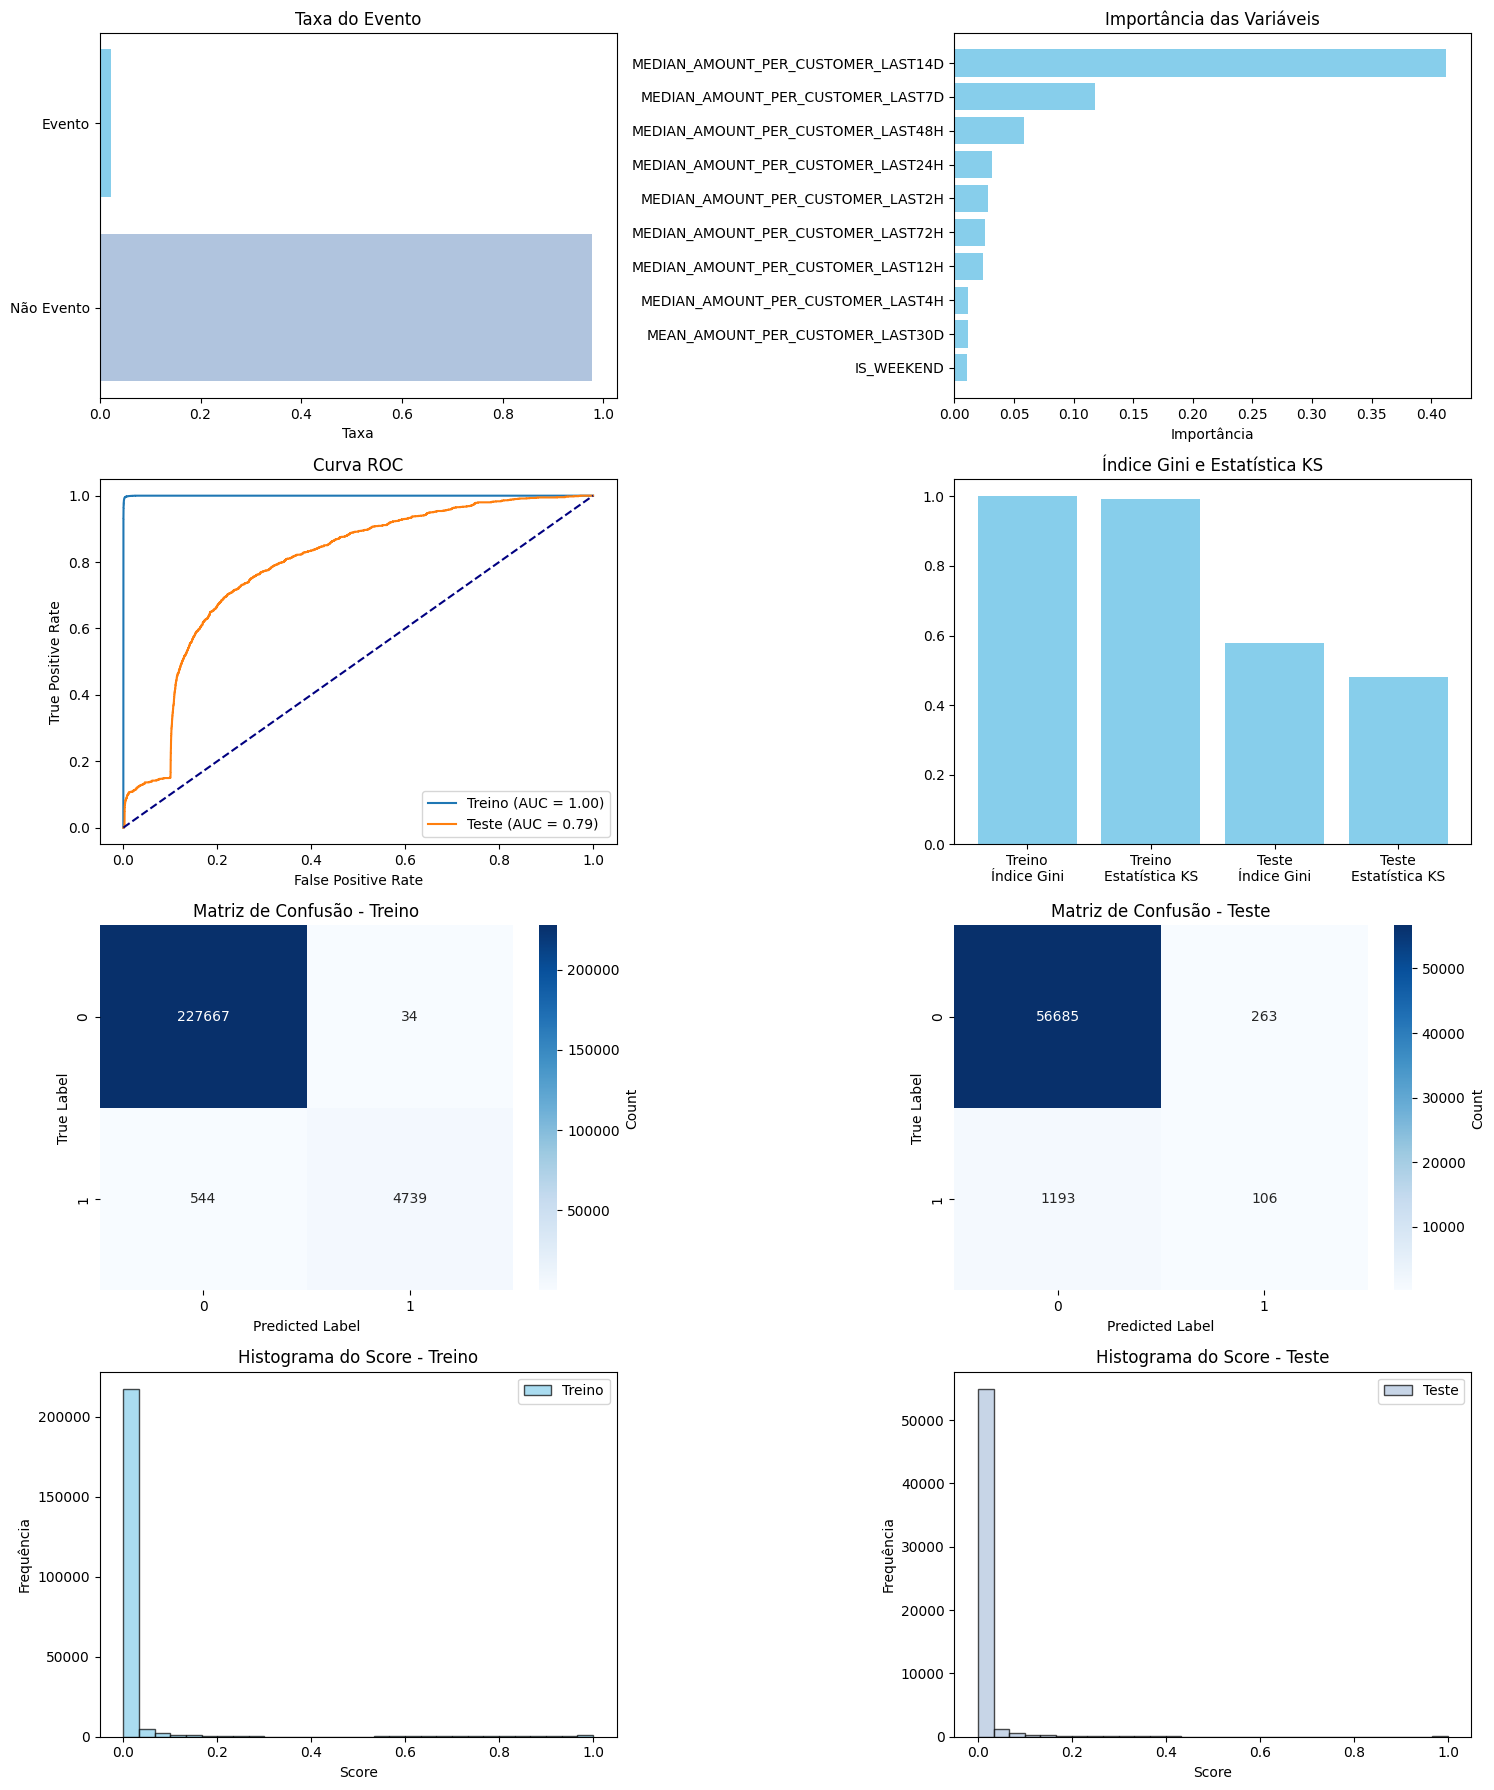

In [ ]:
best_params = {'n_estimators': 497, 'max_depth': 9, 'learning_rate': 0.05064131970082176, 'subsample': 0.9017014890228775, 'colsample_bytree': 0.7349176134551406, 'gamma': 3.357582904408152e-05, 'reg_alpha': 0.9974231664030752, 'reg_lambda': 3.4312469095456225e-05, 'min_child_weight': 5}

features = X_train_processed.columns
# modelo_simplificado_v1_tuned = best_algorithm_tuned = XGBClassifier(random_state=0,**study.best_params)
modelo_simplificado_v1_tuned = best_algorithm_tuned = XGBClassifier(random_state=0,**best_params)
modelo_simplificado_v1_tuned.fit(X_train_processed[vars_selected_v1],y_train)
plot_metrics(best_algorithm_tuned, X_train_processed[vars_selected_v1], y_train, X_test_processed[vars_selected_v1], y_test, features)

y_simplificado_probs_tuned = modelo_simplificado_v1_tuned.predict_proba(X_test_processed[vars_selected_v1])[:,1]

### 9.8 Ajuste no threshold

Como não houve mudança no modelo após tunar hiperparâmetros, não precisaremos reajustar o threshold. Entretanto, se houvesse alguma mudança durante a etapa de tuning, seria necessário reajustar o threshold para avaliar o desempenho (Precision e Recall).

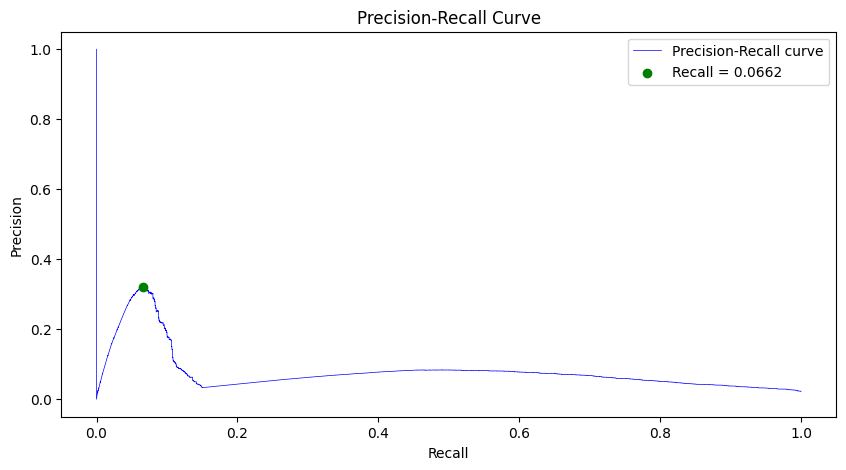

Priorizando a configuração de melhor F1-score:
Melhor F1-score: 0.1436
Threshold correspondente ao F1-score máximo: 4.336140409577638e-05
Precision: 0.08379528168106226
Recall: 0.5003849114703618
----------------------------------------------------------------------
Priorizando outra configuração com menor recall entretanto um maior precision:
Precision: 0.3209
Recall: 0.0662
Threshold: 0.6762828826904297
F1-score: 0.10975732011073666


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

# Supondo que você já tenha os arrays: y_true e y_pred_proba
precision_simplificado_tuned, recall_simplificado_tuned, thresholds_tuned = precision_recall_curve(y_test, y_simplificado_probs_tuned)

# Calcular o F1-score para cada ponto
f1_scores = 2 * (precision_simplificado_tuned * recall_simplificado_tuned) / (precision_simplificado_tuned + recall_simplificado_tuned + 1e-32)

# Encontrar o índice que maximiza o F1-score
best_f1_index = np.argmax(f1_scores)
best_threshold = thresholds_tuned[best_f1_index - 1]  # -1 para alinhar com o tamanho do array de thresholds
best_f1_score = f1_scores[best_f1_index]

# Encontrar o índice onde o recall é aproximadamente 0.0662
recall_target = 0.0662
recall_index = (np.abs(recall_simplificado_tuned - recall_target)).argmin()

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 5))
plt.plot(recall_simplificado_tuned, precision_simplificado_tuned, color='b', lw=0.5, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Marcar o ponto onde recall é 0.0662
plt.scatter(recall_simplificado_tuned[recall_index], precision_simplificado_tuned[recall_index], color='green', label=f'Recall = {recall_target}', zorder=2)

plt.legend()
plt.show()

print('Priorizando a configuração de melhor F1-score:')
print(f'Melhor F1-score: {best_f1_score:.4f}')
print(f'Threshold correspondente ao F1-score máximo: {best_threshold}')
print(f'Precision: {precision_simplificado_tuned[best_f1_index]}')
print(f'Recall: {recall_simplificado_tuned[best_f1_index]}')

f1_score = 2 * (precision_simplificado_tuned[recall_index] * recall_target) / (precision_simplificado_tuned[recall_index] + recall_target + 1e-32)
print(70*'-')
print('Priorizando outra configuração com menor recall entretanto um maior precision:')
print(f'Precision: {precision_simplificado_tuned[recall_index]:.4f}')
print(f'Recall: {recall_simplificado_tuned[recall_index]:.4f}')
print(f'Threshold: {thresholds_tuned[recall_index-1]:.16f}')
print(f'F1-score: {f1_score}')

### 9.9 Avaliação dos resultados por mês de referência

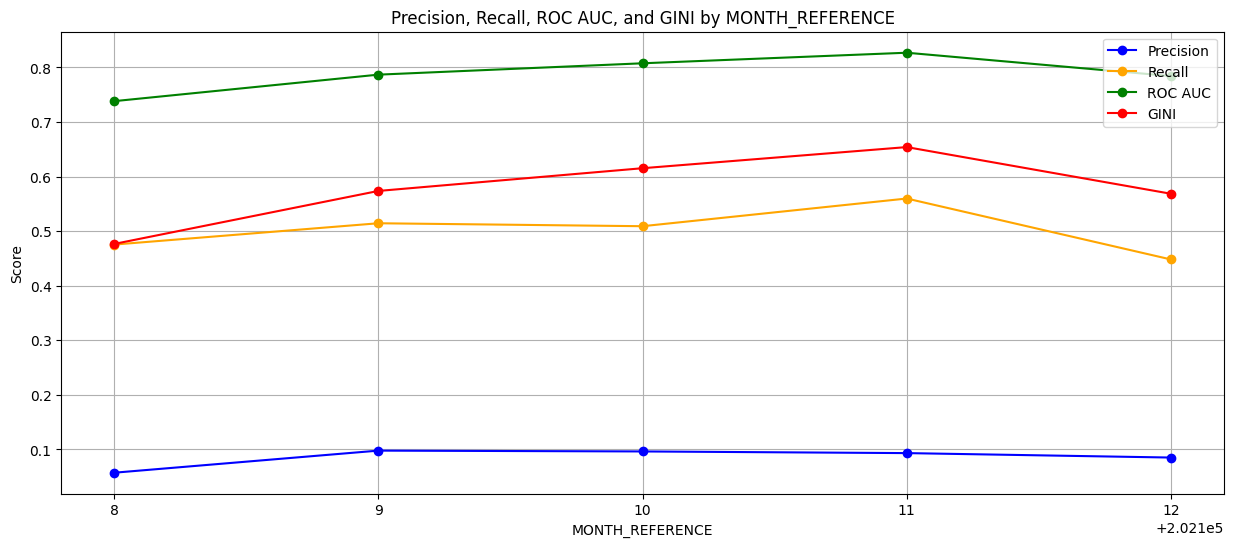

In [ ]:
from sklearn.metrics import roc_auc_score

# Lista para armazenar os resultados
results = []

base_teste_vars_pred = X_test_processed[vars_selected_v1].copy()
base_teste_vars_pred.loc[:,'TX_FRAUDE'] = y_test.reset_index(drop=True)
base_teste_vars_pred.loc[:,'SCORE_FRAUDE'] = y_simplificado_probs_tuned
base_teste_vars_pred.loc[:,'PRED_FRAUDE'] = (y_simplificado_probs_tuned >= best_threshold).astype(int)
base_teste_vars_pred.loc[:,'MONTH_REFERENCE'] = X_test['MONTH_REFERENCE'].reset_index(drop=True)

base_scores = X_test.copy()
base_scores.loc[:,'SCORE_FRAUDE_XGBOOST'] = y_simplificado_probs_tuned
base_scores.loc[:,'PRED_FRAUDE_XGBOOST'] = (y_simplificado_probs_tuned >= best_threshold).astype(int)

# Calcular precision, recall, roc_auc e gini por safra
for safra in base_teste_vars_pred['MONTH_REFERENCE'].unique():
    subset = base_teste_vars_pred[base_teste_vars_pred['MONTH_REFERENCE'] == safra]

    # Precision e Recall
    precision = precision_score(subset['TX_FRAUDE'], subset['PRED_FRAUDE'], zero_division=0)
    recall = recall_score(subset['TX_FRAUDE'], subset['PRED_FRAUDE'], zero_division=0)

    # ROC AUC
    if subset['TX_FRAUDE'].nunique() > 1:  # Garantir que existem ambas as classes (0 e 1)
        roc_auc = roc_auc_score(subset['TX_FRAUDE'], subset['SCORE_FRAUDE'])
    else:
        roc_auc = 0.5  # Valor neutro quando só há uma classe

    # GINI
    gini = 2 * roc_auc - 1

    # Armazenar os resultados
    results.append({
        'MONTH_REFERENCE': safra,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'gini': gini
    })

# Criar um DataFrame com os resultados
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='MONTH_REFERENCE')

# Converter a coluna 'MONTH_REFERENCE' para int
results_df['MONTH_REFERENCE'] = results_df['MONTH_REFERENCE'].astype(int)

# Plotar gráficos de linhas
plt.figure(figsize=(15, 6))

# Precision e Recall
plt.plot(results_df['MONTH_REFERENCE'], results_df['precision'], marker='o', label='Precision', color='blue')
plt.plot(results_df['MONTH_REFERENCE'], results_df['recall'], marker='o', label='Recall', color='orange')

# ROC AUC e GINI
plt.plot(results_df['MONTH_REFERENCE'], results_df['roc_auc'], marker='o', label='ROC AUC', color='green')
plt.plot(results_df['MONTH_REFERENCE'], results_df['gini'], marker='o', label='GINI', color='red')

plt.title('Precision, Recall, ROC AUC, and GINI by MONTH_REFERENCE')
plt.xlabel('MONTH_REFERENCE')
plt.ylabel('Score')
plt.xticks(results_df['MONTH_REFERENCE'])  # Adicionar ticks no eixo x
plt.grid()
plt.legend()
plt.show()

In [ ]:
results_df

,MONTH_REFERENCE,precision,recall,roc_auc,gini
4,202108,0.057284,0.475410,0.738273,0.476546
3,202109,0.097796,0.514493,0.786856,0.573711
2,202110,0.096286,0.509091,0.807688,0.615376
0,202111,0.093238,0.559829,0.827048,0.654096
1,202112,0.085091,0.448148,0.784280,0.568561


In [ ]:
# Taxa média de fraude na base
avg_fraud = base_teste_vars_pred.TX_FRAUDE.mean()

ref_fraud = base_teste_vars_pred.groupby('MONTH_REFERENCE')['TX_FRAUDE'].mean().reset_index().rename(columns={'TX_FRAUDE':'AVG_FRAUD_PER_MONTH_REFERENCE'})

print(f'Taxa média de fraude na base: {100*avg_fraud:.2f}%')

ref_fraud

Taxa média de fraude na base: 2.23%


,MONTH_REFERENCE,AVG_FRAUD_PER_MONTH_REFERENCE
0,202108.0,0.020586
1,202109.0,0.023836
2,202110.0,0.023339
3,202111.0,0.020353
4,202112.0,0.023407


In [ ]:
# Exportar o DataFrame para um arquivo Excel (.xlsx)
base_teste_vars_pred.to_excel('base_teste_vars_pred.xlsx', index=False)

from google.colab import files

# Baixar o arquivo Excel gerado
files.download('base_teste_vars_pred.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 9.10 Salvar base com scores dados pelo Random Forest

In [ ]:
# Testar outros modelos
algoritmo = RandomForestClassifier(random_state=0)

# Treino do modelo
algoritmo.fit(X_train_processed,y_train)

# Realizar predições
base_scores['SCORE_FRAUDE_RANDOM_FOREST'] = algoritmo.predict_proba(X_test_processed)[:,1]
base_scores['PRED_FRAUDE_RANDOM_FOREST'] = algoritmo.predict(X_test_processed)

# Marcar o target
base_scores['TX_FRAUDE'] = y_test.copy()

# Exportar o DataFrame para um arquivo Excel (.xlsx)
base_scores.to_excel('base_scores.xlsx', index=False)

from google.colab import files

# Baixar o arquivo Excel gerado
files.download('base_scores.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>